# multiv Tutorial 2
This tutorial demonstrates more uses of slicer and sampling objects from multiv package.<br>
You are recommended to read multiv_tutorial.ipynb first before reading this.<br>

In [1]:
from multivh3 import *
%matplotlib inline

# Positive Oversampler 2D
Given a binary array (i.e. containing only 0 and 1) as shown in the following,
we want samples of slices like those in Tutorial 1, except that the slice is centered at where 1 with the specified probability. The following image shows the positions of centers available are marked in blue. The blue points are not the same as all black boxes since we limit them by the shape of the slice. The red crosses mark the origin and the region near the origin. 
<img src="Image Store\PositiveOS2D.jpg">
The red rectangle shows an example of such slice.
<img src="Image Store\PositiveOS2D_example.jpg">

In [2]:
from matplotlib.ticker import AutoMinorLocator
class POSampler2D(Sampler2D):
    def __init__(self, shape2D, slice_shape):
        super(POSampler2D, self).__init__(shape2D, slice_shape)
        self.positive_rate = 0.8
        self.positive_indices = None
        self.size_of_positive_indices = None
    
    def set_positive_indices(self, binary_map, verbose=10):
        self.positive_indices = self.find_index_where_equal(binary_map, 1, verbose=verbose)
        self.size_of_positive_indices = len(self.positive_indices)
        if verbose > 9: print("get_center_biased().size_of_positive_indices=%s"%(str(self.size_of_positive_indices)))
        if verbose > 19:
            temp = np.array(self.positive_indices).transpose()
            s = binary_map.shape
            fig = plt.figure()
            ax = fig.add_subplot(111)
            cax = ax.pcolor(binary_map.transpose(), cmap='Greys')
            ax.scatter(temp[0] + 0.5, temp[1] + 0.5)
            ax.scatter(np.array([0,1])+ 0.5,np.array([0,1])+ 0.5, c='r', marker='x')
            ax.set_title("set_positive_indices()")
            plt.yticks(np.arange(0, s[1], step=1))
            plt.grid(1)
            plt.colorbar(cax)
            plt.show()
        return
    
    def get_center_biased(self, binary_map, verbose=10):
        coin = np.random.uniform()       
        if coin < self.positive_rate:
            # draw from region with 1
            if verbose > 9: print("get_center_biased(). Drawing from 1.")
            discrete_coin = np.random.randint(0, self.size_of_positive_indices)
            slice_center = self.positive_indices[discrete_coin]
            one_slice = self.get_slice(slice_center)
        else:
            if verbose > 9: print("get_center_biased(). Drawing from 1.")
            slice_center = self.get_center()
            one_slice = self.get_slice(slice_center)    
        return slice_center
    
    def find_index_where_equal(self, x, value, verbose=0):
        temp = np.array(np.where(x==value)).transpose()
        # Make sure that the positive indices lie within cx_range, cy_range
        positive_centers = []
        if verbose > 9: print("find_index_where_equal(). self.cx_range=%s, self.cy_range=%s"%(str(self.cx_range),str(self.cy_range)))
        if verbose > 9: print("Centers available for positive oversampling (y, x):")
        for x_coord, y_coord in temp:
            if not (x_coord < self.cx_range[1] and self.cx_range[0] <= x_coord) : continue
            if not (y_coord < self.cy_range[1] and self.cy_range[0] <= y_coord) : continue
            if verbose > 9: print("  ",(y_coord, x_coord))
            positive_centers.append((x_coord, y_coord))
        return positive_centers
        
def visualize_one_slice(img_arr, sampler2Dobj, slice_center, one_slice):
    s = img_arr.shape
    xran, yran = range(sampler2Dobj.full_shape[0])[one_slice[0]], range(sampler2Dobj.full_shape[1])[one_slice[1]]
    rect = patches.Rectangle((xran[0], yran[0]),len(xran),len(yran),linewidth=5,edgecolor='r',facecolor='none')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.pcolor(img_arr, cmap='Greys')
    ax.scatter(slice_center[0]+0.5,slice_center[1]+0.5, c='r', marker='x')
    ax.add_patch(rect)
    ax.set_title( str(i) + ":" + str(one_slice))
    plt.yticks(np.arange(0, s[0], step=1))
    plt.grid(1)
    plt.colorbar(cax)

def create_binary_map(size, p=0.5):
    temp = np.random.uniform(size=size)
    return np.array(temp < p, dtype=int)

[[0 0 0 1 0 1 0 0]
 [0 0 0 1 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1]
 [0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 1 0]]
find_index_where_equal(). self.cx_range=[1, 6], self.cy_range=[1, 11]
Centers available for positive oversampling (y, x):
   (3, 1)
   (4, 1)
   (7, 3)
   (10, 3)
   (2, 4)
   (4, 4)
   (10, 4)
   (1, 5)
   (8, 5)
get_center_biased().size_of_positive_indices=9


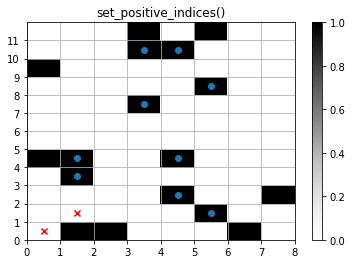

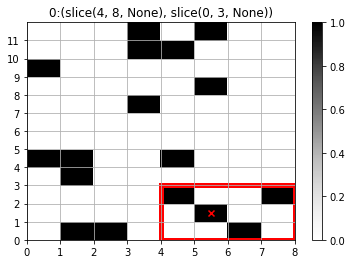

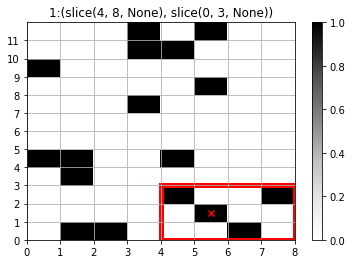

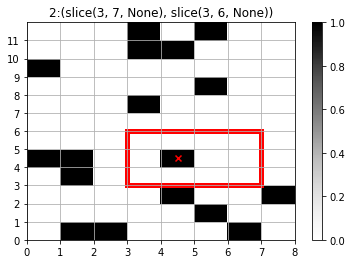

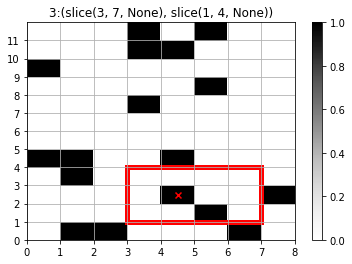

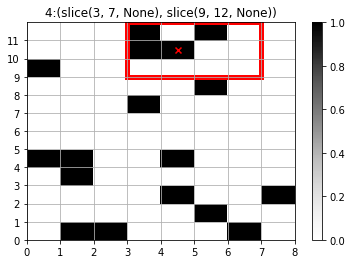

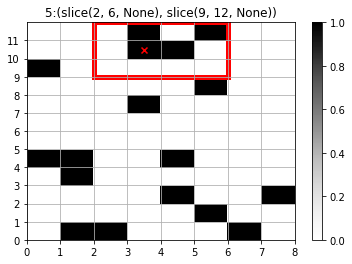

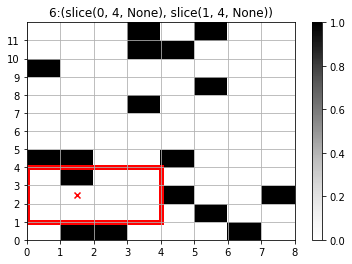

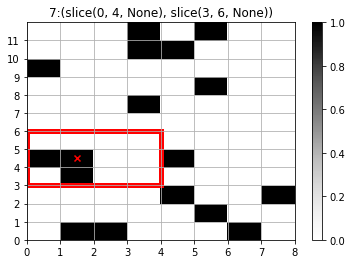

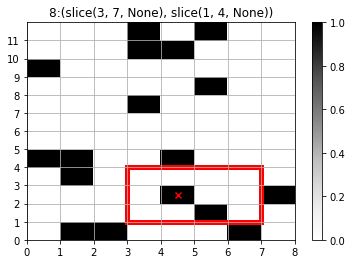

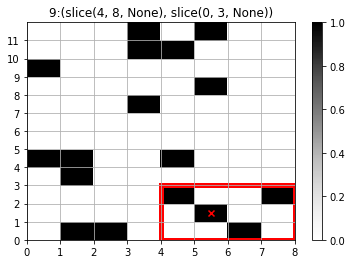

In [3]:
''' Params
shapeND: the full shape of the entire object.
slice_shape: [[x_lower, x_upper],[y_lower, y_upper]]
  From red rectangle shown in the image, x_lower (int) corresponds to the number of cells to the left of the center (x mark),
  x_upper to the right, y_lower below and y_upper above the x mark.
positive_rate: real number between 0 and 1. It is the probability at which the slice is drawn such that the center of the slice
  has value 1 in the binary map.
'''
shape2D = [8,12]
slice_shape = [[1,2],[1,1]]
n_sample = 10
positive_rate = 0.8

x = create_binary_map(shape2D, p=0.2)
img_arr = x.transpose()
print(np.flipud(img_arr))

""" Setting up """
s2 = POSampler2D(shape2D, slice_shape)
s2.set_center_range(padding=None, verbose=0)
s2.positive_rate = positive_rate
s2.set_positive_indices(x, verbose=20)

for i in range(n_sample):
    """ Here we sample the slices that we want! """
    slice_center = s2.get_center_biased(x, verbose=0) # randomly generate a center based on the specification in set_center_range()
    one_slice = s2.get_slice(slice_center) # get the random sample!
    visualize_one_slice(img_arr, s2, slice_center, one_slice)
plt.show()

# MultiView Positive Oversampler 2D
This is like Positive Oversampler 2D, except that each slice has generated with an "envelop" slice, which gives a multi-view sampling.

In [4]:
class MultiViewPO2D(POSampler2D):
    def __init__(self, shape2D, slice_shape, shell_shape):
        super(MultiViewPO2D, self).__init__(shape2D, slice_shape)
        self.assert_shell_shape_is_larger(shell_shape)
        self.shell_shape = shell_shape
        
    def assert_shell_shape_is_larger(self, shell_shape):
        assert(np.all(shell_shape[0]>=self.slice_shape[0]))
        assert(np.all(shell_shape[1]>=self.slice_shape[1]))
        
    def set_center_range(self, padding=None, verbose=0):
        if padding is None:
            nxl, nxu = self.shell_shape[0][0], self.shell_shape[0][1]
            nyl, nyu = self.shell_shape[1][0], self.shell_shape[1][1]
            self.cx_range = [nxl, self.full_shape[0] - nxu]
            self.cy_range = [nyl, self.full_shape[1] - nyu]
            if verbose > 9: print("  self.cx_range, self.cy_range: ",self.cx_range, ",", self.cy_range)
    def get_shell_slice(self, slice_center):
        this_center_x, this_center_y = slice_center	
        xlower, xupper = this_center_x - self.shell_shape[0][0], this_center_x + self.shell_shape[0][1]
        ylower, yupper = this_center_y - self.shell_shape[1][0], this_center_y + self.shell_shape[1][1] 
        """ plus 1 is needed since slice upper limit is exclusive, while the lower limit is inclusive
        """
        xslice = slice(int(xlower), int(xupper) + 1, None)
        yslice = slice(int(ylower), int(yupper) + 1, None)
        return (xslice, yslice)

def visualize_2D_dual_view(i, img_arr, rect, rectS, slice_center, one_slice):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.pcolor(img_arr, cmap='Greys')
    ax.scatter(slice_center[0]+0.5,slice_center[1]+0.5, c='r', marker='x')
    ax.add_patch(rectS)
    ax.add_patch(rect)
    ax.set_title( str(i) + ":" + str(one_slice))
    plt.colorbar(cax)
    plt.show()


transposed array:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]]
find_index_where_equal(). self.cx_range=[2, 5], self.cy_range=[2, 10]
Centers available for positive oversampling (y, x):
   (3, 2)
   (9, 3)
   (6, 4)
get_center_biased().size_of_positive_indices=3


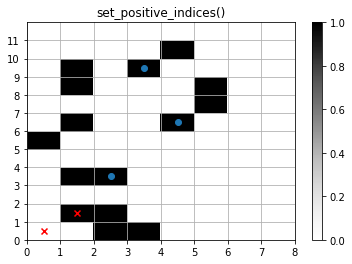

get_center_biased(). Drawing from 1.


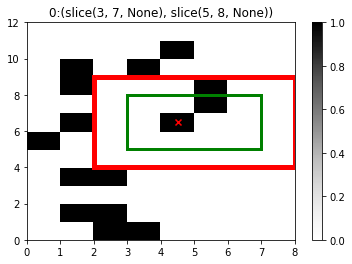

get_center_biased(). Drawing from 1.


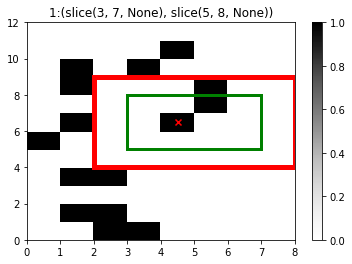

get_center_biased(). Drawing from 1.


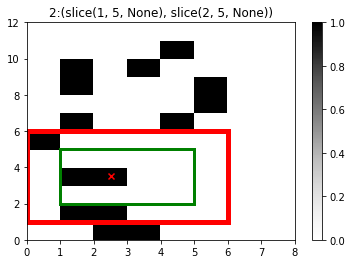

get_center_biased(). Drawing from 1.


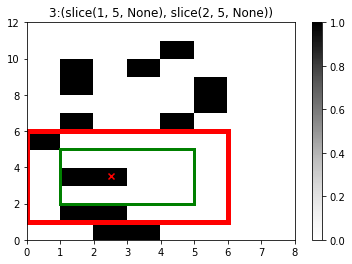

get_center_biased(). Drawing from 1.


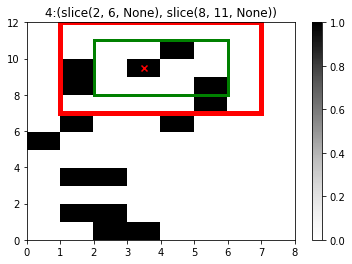

get_center_biased(). Drawing from 1.


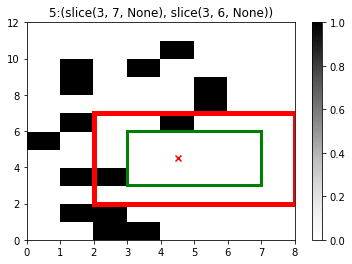

get_center_biased(). Drawing from 1.


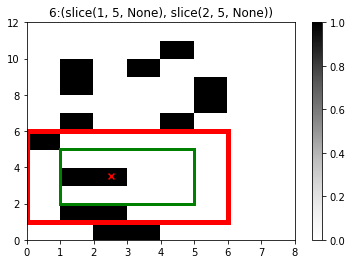

get_center_biased(). Drawing from 1.


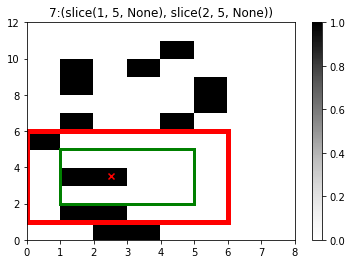

get_center_biased(). Drawing from 1.


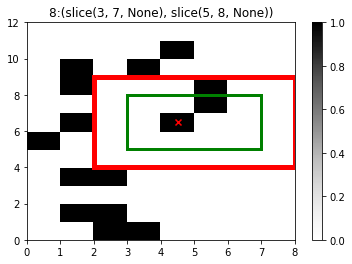

get_center_biased(). Drawing from 1.


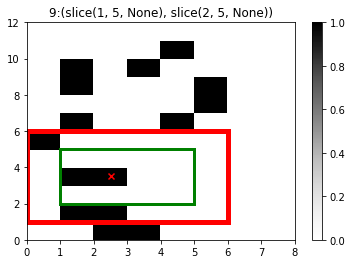

In [5]:
shape2D = [8,12]
slice_shape = [[1,2],[1,1]]
shell_shape = [[2,3],[2,2]]
n_sample = 10
positive_rate = 0.8

x = create_binary_map(shape2D, p=0.2)
img_arr = x.transpose()
print("\ntransposed array:\n",np.flipud(img_arr))

mpos2D = MultiViewPO2D(shape2D, slice_shape, shell_shape)
mpos2D.set_center_range(padding=None, verbose=0)
mpos2D.positive_rate = positive_rate
mpos2D.set_positive_indices(x, verbose=20)

for i in range(n_sample):
    """ Here we sample the slices that we want! """
    slice_center = mpos2D.get_center_biased(x, verbose=10) # randomly generate a center based on the specification in set_center_range()
    one_slice = mpos2D.get_slice(slice_center) # get the random sample!
    one_shell_slice = mpos2D.get_shell_slice(slice_center)
    
    xran, yran = range(mpos2D.full_shape[0])[one_slice[0]], range(mpos2D.full_shape[1])[one_slice[1]]
    xSran, ySran = range(mpos2D.full_shape[0])[one_shell_slice[0]], range(mpos2D.full_shape[1])[one_shell_slice[1]]
    rect = patches.Rectangle((xran[0], yran[0]),len(xran),len(yran),linewidth=3,edgecolor='g',facecolor='none')
    rectS = patches.Rectangle((xSran[0], ySran[0]),len(xSran),len(ySran),linewidth=5,edgecolor='r',facecolor='none')
    visualize_2D_dual_view(i, img_arr, rect, rectS, slice_center, one_slice)

# Positive Oversampler 3D
Same as Positive Oversampler 2D except 3D

In [6]:
class POSampler3D(Sampler3D):
    def __init__(self, shape3D, slice_shape):
        super(POSampler3D, self).__init__(shape3D, slice_shape)
        self.positive_rate = 0.8
        self.positive_indices = None
        self.size_of_positive_indices = None
    
    def set_positive_indices(self, binary_map, verbose=10):
        self.positive_indices = self.find_index_where_equal(binary_map, 1, verbose=verbose)
        self.size_of_positive_indices = len(self.positive_indices)
        if verbose > 9: print("get_center_biased().size_of_positive_indices=%s"%(str(self.size_of_positive_indices)))
        if verbose > 19: 
            print("set_positive_indices. Showing centers for positive oversampling.")
            s = binary_map.shape
            available_centers = np.zeros(s)
            for i in self.positive_indices:
                available_centers[i]=1
            colors, colors2 = '#ff000010', 'red' 
            ax = make_ax(grid=True)
            ax.voxels(binary_map, facecolors=colors, edgecolors=None)
            ax.voxels(available_centers, facecolors=colors2, edgecolors=None)
            this_title = "set_positive_indices()"
            ax.set_title(this_title)
            plt.show()
        return
    
    def get_center_biased(self, binary_map, verbose=10):
        coin = np.random.uniform()       
        if coin < self.positive_rate:
            # draw from region with 1
            if verbose > 9: print("get_center_biased(). Drawing from 1.")
            discrete_coin = np.random.randint(0, self.size_of_positive_indices)
            slice_center = self.positive_indices[discrete_coin]
            one_slice = self.get_slice(slice_center)
        else:
            if verbose > 9: print("get_center_biased(). Drawing freely.")
            slice_center = self.get_center()
            one_slice = self.get_slice(slice_center)    
        return slice_center
    
    def find_index_where_equal(self, x, value, verbose=0):
        temp = np.array(np.where(x==value)).transpose()
        # Make sure that the positive indices lie within cx_range, cy_range
        positive_centers = []
        if verbose > 9: print("find_index_where_equal(). self.cx_range=%s, self.cy_range=%s"%(str(self.cx_range),str(self.cy_range)))
        if verbose > 9: print("Centers available for positive oversampling (x,y,z):")
        for x_coord, y_coord, z_coord in temp:
            if not (x_coord < self.cx_range[1] and self.cx_range[0] <= x_coord) : continue
            if not (y_coord < self.cy_range[1] and self.cy_range[0] <= y_coord) : continue
            if not (z_coord < self.cz_range[1] and self.cz_range[0] <= z_coord) : continue
            if verbose > 9: print("  ",(y_coord, x_coord, z_coord),":", x[x_coord, y_coord, z_coord])
            positive_centers.append((x_coord, y_coord, z_coord))
        return positive_centers

def make_ax(grid=False):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax
    
def visualize_one_slice2(img_arr, slice_center, one_slice):
    alpha=0.2
    s = img_arr.shape
    filled, filled2, filled3 = np.ones(s), np.zeros(s), np.zeros(s)
    filled2[one_slice], filled3[slice_center] = 1, 1
    xran, yran, zran = range(s[0])[one_slice[0]], range(s[1])[one_slice[1]], range(s[2])[one_slice[2]]
    xmin, xmax, ymin, ymax, zmin, zmax = np.min(xran), np.max(xran), np.min(yran), np.max(yran), np.min(zran), np.max(zran)
    colors = np.zeros(s + (4,))
    colors[:,:,:,2], colors[:,:,:,3] = img_arr/np.max(img_arr), alpha
    colors2, colors3 = '#ff000050', '#ff000090'  

    filled2[one_slice] = np.max(filled) + 2
    ax = make_ax(grid=True)
    ax.voxels(filled3, facecolors=colors3, edgecolors='black')
    ax.voxels(filled2, facecolors=colors2, edgecolors='grey')
    ax.voxels(filled, facecolors=colors, edgecolors=None)
    this_string = "(" + str(xmin) + "," + str(ymin) + ","  + str(zmin) + ")"
    this_string2 = "(" + str(xmax) + "," + str(ymax) + ","  + str(zmax) + ")"
    this_title = str(i) + ":" + str(one_slice)
    ax.text(xmin-0.5, ymin-0.5, zmin-0.5, s=this_string, color='y', fontsize=12)
    ax.text(xmax+0.5, ymax+0.5, zmax+1.5, s=this_string2, color='y', fontsize=12)
    ax.set_title(this_title)
    plt.show()

find_index_where_equal(). self.cx_range=[1, 6], self.cy_range=[1, 7]
Centers available for positive oversampling (x,y,z):
   (3, 2, 3) : 1
   (4, 2, 3) : 1
   (2, 5, 2) : 1
get_center_biased().size_of_positive_indices=3
set_positive_indices. Showing centers for positive oversampling.


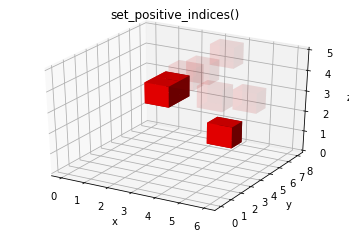


 ===== Slices =====

get_center_biased(). Drawing from 1.


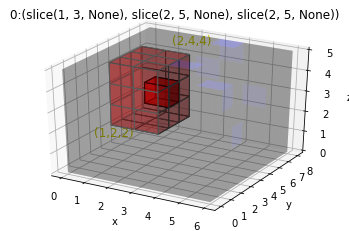

get_center_biased(). Drawing from 1.


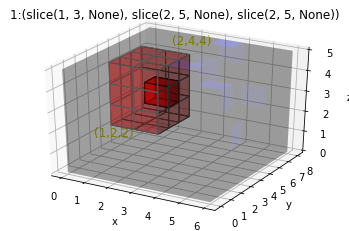

get_center_biased(). Drawing freely.


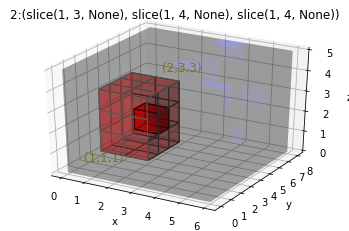

get_center_biased(). Drawing from 1.


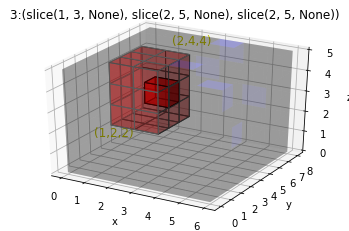

get_center_biased(). Drawing from 1.


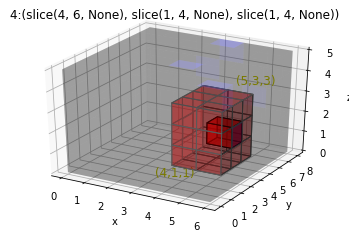

get_center_biased(). Drawing freely.


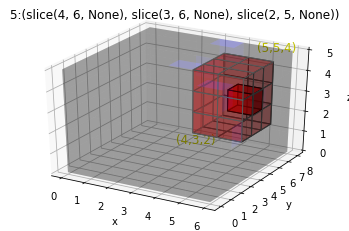

get_center_biased(). Drawing from 1.


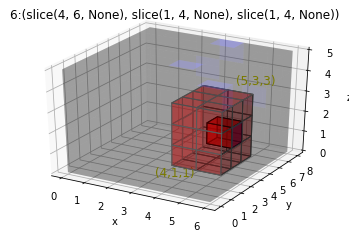

get_center_biased(). Drawing from 1.


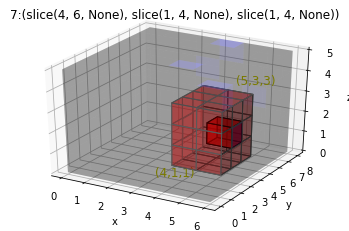

get_center_biased(). Drawing from 1.


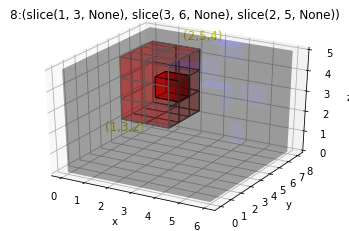

get_center_biased(). Drawing freely.


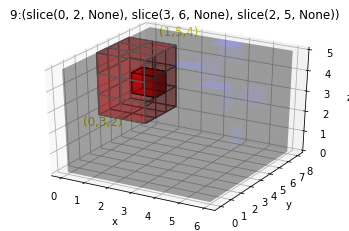

In [7]:
shapeND = [6,8,5]
slice_shape = [[1,0],[1,1],[1,1]]
n_sample = 10
positive_rate = 0.8

x = create_binary_map(shapeND, p=0.02)
img_arr = x

s3 = POSampler3D(shapeND, slice_shape)
s3.set_center_range(padding=None, verbose=0)
s3.positive_rate = positive_rate
s3.set_positive_indices(x, verbose=20)

print("\n ===== Slices =====\n")
for i in range(n_sample):
    slice_center = s3.get_center_biased(x)
    one_slice = s3.get_slice(slice_center)
    visualize_one_slice2(x, slice_center, one_slice)

# MultiView Positive Oversampler 3D
Same as MultiView Positive Oversampler 2D, except 3D

In [8]:
class MultiViewPO3D(POSampler3D):
    """MultiViewPO3D"""
    def __init__(self, full_shape, slice_shape, shell_shape):
        super(MultiViewPO3D, self).__init__(full_shape, slice_shape)
        self.assert_shell_shape_is_larger(shell_shape)
        self.shell_shape = shell_shape

    def assert_shell_shape_is_larger(self, shell_shape):
        assert(np.all(shell_shape[0]>=self.slice_shape[0]))
        assert(np.all(shell_shape[1]>=self.slice_shape[1]))
        assert(np.all(shell_shape[2]>=self.slice_shape[2]))

    def get_shell_slice(self, slice_center):
        this_center_x, this_center_y, this_center_z = slice_center	
        xlower, xupper = this_center_x - self.shell_shape[0][0], this_center_x + self.shell_shape[0][1]
        ylower, yupper = this_center_y - self.shell_shape[1][0], this_center_y + self.shell_shape[1][1] 
        zlower, zupper = this_center_z - self.shell_shape[2][0], this_center_z + self.shell_shape[2][1] 
        """ plus 1 is needed since slice upper limit is exclusive, while the lower limit is inclusive
        """
        xslice = slice(int(xlower), int(xupper) + 1, None)
        yslice = slice(int(ylower), int(yupper) + 1, None)
        zslice = slice(int(zlower), int(zupper) + 1, None)
        return (xslice, yslice,zslice)

    def set_center_range(self, padding=None, verbose=0):
        if padding is None:
            nxl, nxu = self.shell_shape[0][0], self.shell_shape[0][1]
            nyl, nyu = self.shell_shape[1][0], self.shell_shape[1][1]
            nzl, nzu = self.shell_shape[2][0], self.shell_shape[2][1]
            self.cx_range = [nxl, self.full_shape[0] - nxu]
            self.cy_range = [nyl, self.full_shape[1] - nyu]
            self.cz_range = [nzl, self.full_shape[2] - nzu]
            if verbose > 9: print("  self.cx_range, self.cy_range, self.cz_range: ",self.cx_range, ",", self.cy_range, ",", self.cz_range)

def visualize_dual3D(img_arr, i, slice_center, one_slice, shell_slice):
    alpha=0.2
    s = img_arr.shape
    filled, filled2, filled3, filled4 = np.ones(s), np.zeros(s), np.zeros(s), np.zeros(s)
    filled2[one_slice], filled3[slice_center], filled4[shell_slice] = 1, 1, 1
    xran, yran, zran = range(s[0])[shell_slice[0]], range(s[1])[shell_slice[1]], range(s[2])[shell_slice[2]]
    xmin, xmax, ymin, ymax, zmin, zmax = np.min(xran), np.max(xran), np.min(yran), np.max(yran), np.min(zran), np.max(zran)

    colors = np.zeros(s + (4,))
    colors[:,:,:,2], colors[:,:,:,3] = img_arr/np.max(img_arr), alpha
    colors2, colors3, colors4 = '#ff000050', '#ff000090' ,'#00550010' 

    filled2[one_slice] = np.max(filled) + 2
    ax = make_ax(grid=True)
    ax.voxels(filled4, facecolors=colors4, edgecolors='grey')
    ax.voxels(filled3, facecolors=colors3, edgecolors='black')
    ax.voxels(filled2, facecolors=colors2, edgecolors='grey')
    ax.voxels(filled, facecolors=colors, edgecolors=None)
    this_string = "(" + str(xmin) + "," + str(ymin) + ","  + str(zmin) + ")"
    this_string2 = "(" + str(xmax) + "," + str(ymax) + ","  + str(zmax) + ")"
    this_title = str(i) + ":" + str(one_slice)
    ax.text(xmin-0.5, ymin-0.5, zmin-0.5, s=this_string, color='y', fontsize=12)
    ax.text(xmax+0.5, ymax+0.5, zmax+1.5, s=this_string2, color='y', fontsize=12)
    ax.set_title(this_title)
    plt.show()

find_index_where_equal(). self.cx_range=[1, 5], self.cy_range=[2, 7]
Centers available for positive oversampling (x,y,z):
   (2, 2, 4) : 1
   (2, 3, 2) : 1
   (4, 3, 3) : 1
   (6, 3, 3) : 1
   (4, 4, 3) : 1
   (4, 4, 4) : 1
   (6, 4, 4) : 1
get_center_biased().size_of_positive_indices=7
set_positive_indices. Showing centers for positive oversampling.


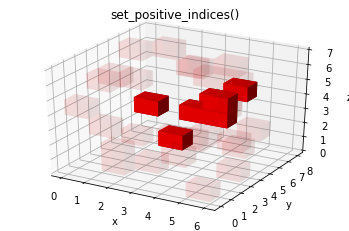


 ===== Slices =====

get_center_biased(). Drawing from 1.


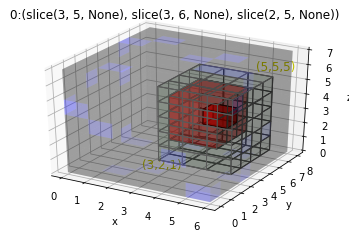

get_center_biased(). Drawing from 1.


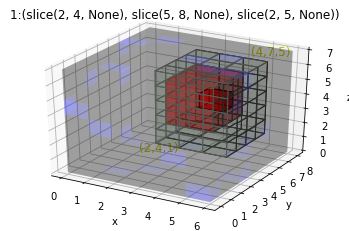

get_center_biased(). Drawing from 1.


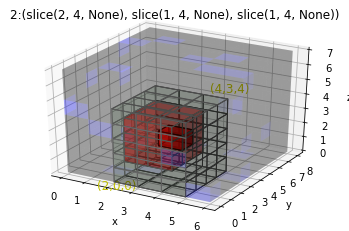

get_center_biased(). Drawing freely.


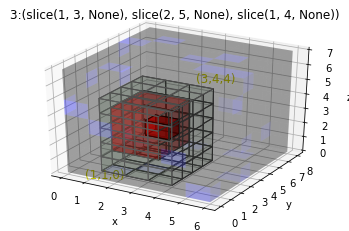

get_center_biased(). Drawing from 1.


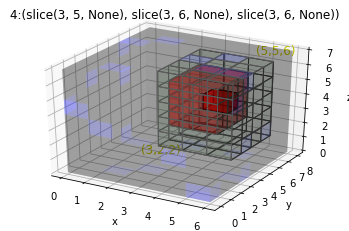

get_center_biased(). Drawing from 1.


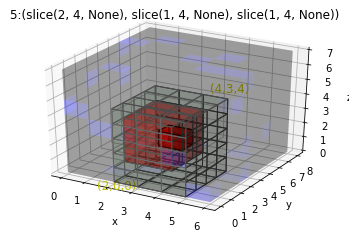

get_center_biased(). Drawing from 1.


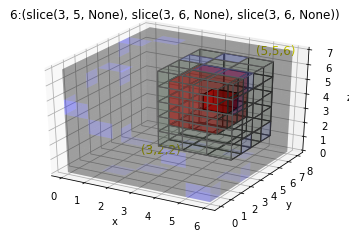

get_center_biased(). Drawing from 1.


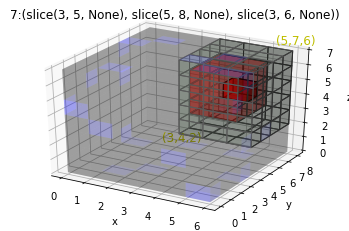

get_center_biased(). Drawing freely.


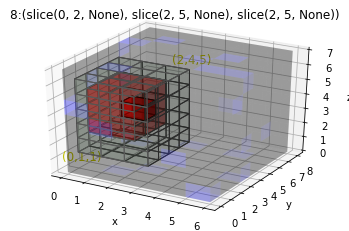

get_center_biased(). Drawing from 1.


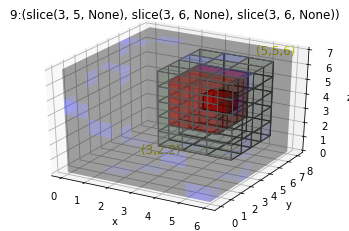

In [9]:
shape3D = [6,8,7]
slice_shape = [[1,0],[1,1],[1,1]]
shell_shape = [[1,1],[2,1],[2,2]]
n_sample = 10
positive_rate = 0.8

x = create_binary_map(shape3D, p=0.1)
img_arr = x

mpos3D = MultiViewPO3D(shape3D, slice_shape, shell_shape)
mpos3D.set_center_range(padding=None, verbose=0)
mpos3D.positive_rate = positive_rate
mpos3D.set_positive_indices(x, verbose=20)

print("\n ===== Slices =====\n")
for i in range(n_sample):
    slice_center = mpos3D.get_center_biased(x)
    one_slice = mpos3D.get_slice(slice_center)
    one_shell_slice = mpos3D.get_shell_slice(slice_center)
    visualize_dual3D(img_arr, i, slice_center, one_slice,  one_shell_slice)